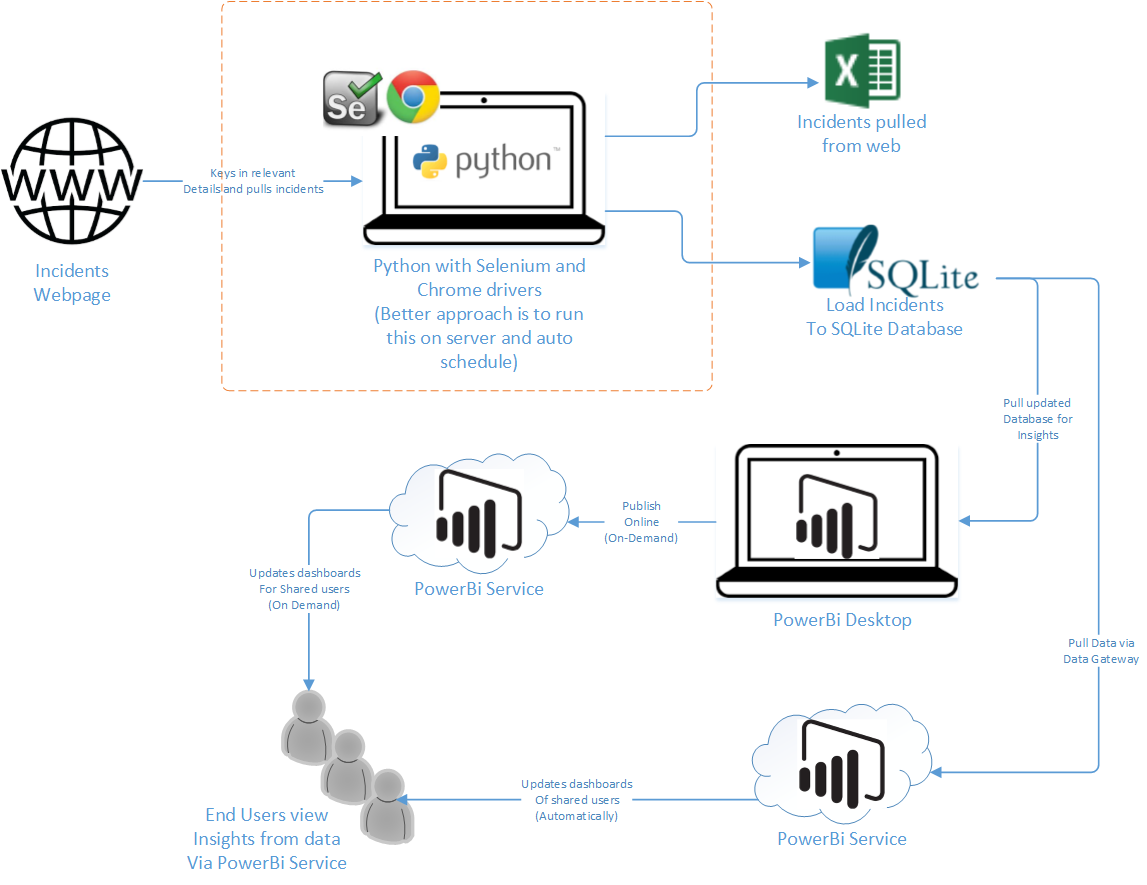

In [56]:
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np

#below 2 lines to run browser in backend
chrome_options = Options()
chrome_options.add_argument("--headless")

#setup webdriver for chrome
driver = webdriver.Chrome(executable_path=r'<### location of chromedriver.exe file ###>',
                          chrome_options=chrome_options)  # Optional argument, if not specified will search path.

#Hit the incident page
driver.get('<### webpage to scrap incidents ###>');

#search for "input text box" on the page and type in value
#repeat as many fields as needed by specifying right element by its name
search_box = driver.find_element_by_name('<### element name on webpage ###>')
search_box.send_keys('<### input value ###>')

#find submit button and click that
submit = driver.find_element_by_name('<### element name on webpage ###>')
submit.click()

#Get page source and save it
page = bs(driver.page_source,"html5lib")

In [58]:
################################################################################
### Remove tkinter message box when scheduling the script to run on a server ###
################################################################################
import sys
import tkinter
from tkinter import messagebox

#Get tkinter TK and we can use it to destroy the window
root = tkinter.Tk()
################################################################################

#Function to get table from page source
def get_table(table):
    pd_html = pd.read_html(str(table),header=0) #first record is header that becomes columns
    pd_html[0] # get the first df that comes out of list of df
    return pd_html[0].loc[:, ~pd_html[0].columns.str.contains('^Unnamed')][:-2] #drop columns that are unnamed and drop last 2 rows

#Function to check if table exist on the page before calling get_table
def check_if_table_exists():    
    try:
        table_check = driver.find_element_by_id('<### element id on webpage ###>')
    except:    
        messagebox.showerror('Error','NO table found on the page')
        root.destroy()
        sys.exit('table not found on the page')

#check if table exists and get the exact table we are looking for from page source to pass it to get_table
check_if_table_exists()
table = page.find('table', id='<### element id on webpage ###>')
pd_table = get_table(table)

No_Exception = True

#check if next page button is available on page. if not available then mark exception
try:
    next_page = driver.find_element_by_name('<### element name on webpage ###>')
except NoSuchElementException:
    No_Exception = False

#Keep checking if next page button is enabled and grab the table from all subsequent pages
while next_page.is_enabled() and No_Exception:
    next_page.click()
    page = bs(driver.page_source,"html5lib")
    check_if_table_exists()
    table = page.find('table', id='<### element id on webpage ###>')
    pd_table = pd_table.append(get_table(table),ignore_index=True)
    try:
        next_page = driver.find_element_by_name('<### element name on webpage ###>')
    except:
        break

################################################################################
### Remove tkinter message box when scheduling the script to run on a server ###
################################################################################
#get rows and columns accumulated from site and display a message box for notification, then kill tkinter root and driver
(rows,cols) = pd_table.shape
messagebox.showinfo('info','Captured {} rows and {} columns'.format(rows,cols))
root.destroy()
driver.quit()
################################################################################

In [59]:
#Extract model and job from Title. ?P<name> is used to name group which comes as column names. expand=True ensure output is df.
#we are looking for specific format of text in title P999_XXX_YY_ZZ_100
model_job = pd_table['Title'].str.extract('[. #](?P<Model>[Pp]\d+)_[A-Z0-9]+_[A-Z0-9]+_(?P<Job>[A-Z0-9]+)_*[A-Z0-9]*',expand=True)
#model_job.columns=['Model','Job']

#get index of model_job that didn't get right model and job from title
index = model_job.index[model_job['Model'].isnull()]

#get those records from table that didn't fit the first regex (model_job has null values)
pd_model_na = pd_table.loc[index]

#get model and job from above records for format P999_XXX_YY_100 in title
model_job_1 = pd_model_na['Title'].str.extract('[. #](?P<Model>[Pp]\d+)_[^ ]*_(?P<Job>[A-Z0-9]+) ',expand=True)

#update new found model and job to original list of models and jobs
model_job.update(model_job_1)

#Fill empty cells with 'N/A' (those that fit two regex models)
model_job.fillna('N/A',inplace=True)

#concatenate pd_table and model_job into final_incident df.
final_incident = pd.concat([pd_table,model_job],axis=1)

In [60]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(r'### Location of Incident_list_output.xlsx ###>', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object. Index=False drops index in output excel.
final_incident.to_excel(writer, sheet_name='Sheet1',index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [61]:
final_incident['Opened']=pd.to_datetime(final_incident['Opened'])
final_incident['Updated']=pd.to_datetime(final_incident['Updated'])
final_incident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 13 columns):
Incident          956 non-null object
Priority          956 non-null object
Status            956 non-null object
Opened            956 non-null datetime64[ns]
Contact           1 non-null object
Assigned Group    956 non-null object
Assigned To       771 non-null object
Service           956 non-null object
CI                946 non-null object
Title             956 non-null object
Updated           956 non-null datetime64[ns]
Model             956 non-null object
Job               956 non-null object
dtypes: datetime64[ns](2), object(11)
memory usage: 97.2+ KB


In [62]:
import sqlite3

# Connect to Sqlite DB and open cursor
conn = sqlite3.connect(r'<### Location of Incident_DB.db ###>')

#load final_incident to sql database
final_incident.to_sql('Incident_DB',conn,if_exists='append',index=False)

# Commit SQL transactions and close connection
conn.commit()
conn.close()

c:\users\a6fkqzz\appdata\local\programs\python\python36\lib\site-packages\pandas\core\generic.py:1362: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)
